In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def softmax(z: np.ndarray) -> np.ndarray:
  """
  Compute the softmax of a 2D numpy array along the specified axis.
  Parameters:
    z (numpy.ndarray): Input array of shape (m, n) where m is the number of samples and n is the number of classes.

  Returns:
    numpy.ndarray: Softmax probabilities of the same shape as input (m, n), where each row sums to 1 and represents the probability distribution over classes for a sample.

  Notes:
      - Applies a normalization trick to prevent numerical instability by subtracting the max value in each row before exponentiation.
  """
  exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
  return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [3]:
def test_softmax():
  """
    Perform basic assertion tests on the softmax function to validate its correctness.
    Tests:
    - Ensure that the output probabilities sum to 1 for each row.
    - Ensure non-negative values (all probabilities should be >= 0).
    - Test on edge cases (e.g., all zeros, very large or small values).
  """
  # Test input
  test_cases = [
  (np.array([[0, 0, 0]]), "All zeros"),
  (np.array([[1, 2, 3]]), "Simple case"),
  (np.array([[1000, 1000, 1000]]), "Large identical values"),
  (np.array([[-1000, -1000, -1000]]), "Small identical values"),
  (np.array([[1, 0, -1]]), "Mixed positive and negative")
  ]

  for i, (z, description) in enumerate(test_cases):
    print(f"Test {i + 1}: {description}")
    result = softmax(z)
    # Check that probabilities sum to 1
    assert np.allclose(result.sum(axis=1), 1), f"Failed: Probabilities do not sum to 1 in {description
    }"
    # Check non-negativity
    assert np.all(result >= 0), f"Failed: Negative probabilities in {description}"
    print("Passed.")
  print("All tests passed for softmax function.")
test_softmax()

Test 1: All zeros
Passed.
Test 2: Simple case
Passed.
Test 3: Large identical values
Passed.
Test 4: Small identical values
Passed.
Test 5: Mixed positive and negative
Passed.
All tests passed for softmax function.


In [4]:
def loss_softmax(y_true, y_pred):
    """
    Compute the cross-entropy loss for a single observation.
    Parameters:
      y_true (numpy.ndarray): True labels (one-hot encoded) of shape (c,).
      y_pred (numpy.ndarray): Predicted probabilities of shape (c,).
    Returns:
      float: Cross-entropy loss for the observation.
    """
    return -np.sum(y_true * np.log(y_pred + 1e-10))

In [5]:
def test_loss_softmax():
  """
    Test the loss_softmax function using a known input and output.
  """
  # Test Case 1: Perfect prediction
  y_true = np.array([0, 1, 0]) # True label (one-hot encoded)
  y_pred = np.array([0.1, 0.8, 0.1]) # Predicted probabilities
  expected_loss = -np.log(0.8) # Expected loss for perfect prediction
  assert np.isclose(loss_softmax(y_true, y_pred), expected_loss), "Test Case 1 Failed"

  # Test Case 2: Incorrect prediction
  y_true = np.array([1, 0, 0]) # True label (one-hot encoded)
  y_pred = np.array([0.3, 0.4, 0.3]) # Predicted probabilities
  expected_loss = -np.log(0.3) # Expected loss for incorrect prediction
  assert np.isclose(loss_softmax(y_true, y_pred), expected_loss), "Test Case 2 Failed"

  # Test Case 3: Edge case with near-zero probability
  y_true = np.array([0, 1, 0]) # True label (one-hot encoded)
  y_pred = np.array([0.01, 0.98, 0.01]) # Predicted probabilities
  expected_loss = -np.log(0.98) # Expected loss for edge case
  assert np.isclose(loss_softmax(y_true, y_pred), expected_loss), "Test Case 3 Failed"
  print("All test cases passed!")
# Run the test
test_loss_softmax()

All test cases passed!


In [6]:
def cost_softmax(X, y, W, b):
    """
    Compute the average cross-entropy cost over all samples.
    Parameters:
      X (numpy.ndarray): Feature matrix of shape (n, d).
      y (numpy.ndarray): True labels (one-hot encoded) of shape (n, c).
      W (numpy.ndarray): Weight matrix of shape (d, c).
      b (numpy.ndarray): Bias vector of shape (c,).
    Returns:
      float: Average cross-entropy cost over all samples.
    """
    n, d = X.shape
    y_pred = softmax(X @ W + b)
    return loss_softmax(y, y_pred) / n

In [7]:
def test_cost_softmax():
  """
    Test the cost_softmax function using a known input and output.
  """
  # Test Case 1: Small dataset with perfect predictions
  X = np.array([[1, 2], [2, 3], [3, 4]]) # Feature matrix (n=3, d=2)
  y = np.array([[1, 0], [0, 1], [1, 0]]) # True labels (n=3, c=2, one-hot encoded)
  W = np.array([[1, -1], [-1, 1]]) # Weight matrix (d=2, c=2)
  b = np.array([0, 0]) # Bias vector (c=2)
  z = np.dot(X, W) + b
  y_pred = softmax(z) # Predicted probabilities
  expected_cost = -np.sum(y * np.log(y_pred + 1e-10)) / X.shape[0] # Compute expected cost
  assert np.isclose(cost_softmax(X, y, W, b), expected_cost), "Test Case 1 Failed"

  # Test Case 2: All-zero weights and bias
  X = np.array([[1, 0], [0, 1], [1, 1]]) # Feature matrix (n=3, d=2)
  y = np.array([[1, 0], [0, 1], [1, 0]]) # True labels (n=3, c=2, one-hot encoded)
  W = np.zeros((2, 2)) # Zero weight matrix
  b = np.zeros(2) # Zero bias vector
  z = np.dot(X, W) + b
  y_pred = softmax(z) # Predicted probabilities (uniform distribution)
  expected_cost = -np.sum(y * np.log(y_pred + 1e-10)) / X.shape[0] # Compute expected cost
  assert np.isclose(cost_softmax(X, y, W, b), expected_cost), "Test Case 2 Failed"
  print("All test cases passed!")
# Run the test
test_cost_softmax()

All test cases passed!


In [8]:
def compute_gradient_softmax(X, y, W, b):
  """
  Compute the gradients of the cost function with respect to weights and biases.
  Parameters:
    X (numpy.ndarray): Feature matrix of shape (n, d).
    y (numpy.ndarray): True labels (one-hot encoded) of shape (n, c).
    W (numpy.ndarray): Weight matrix of shape (d, c).
    b (numpy.ndarray): Bias vector of shape (c,).
  Returns:
    tuple: Gradients with respect to weights (d, c) and biases (c,).
  """
  n, d = X.shape
  y_pred = softmax(X @ W + b)
  grad_W = X.T @ (y_pred -y) / n
  grad_B = np.sum(y_pred - y, axis=0) / n
  return grad_W, grad_B

In [9]:
def test_compute_gradient_softmax():
  # Define simple inputs
  X = np.array([[1, 2], [3, 4]]) # Shape (2, 2)
  y = np.array([[1, 0], [0, 1]]) # Shape (2, 2), one-hot encoded
  W = np.array([[0.1, 0.2], [0.3, 0.4]]) # Shape (2, 2)
  b = np.array([0.01, 0.02]) # Shape (2,)

  # Expected gradients (calculated manually or using a reference implementation)
  z = np.dot(X, W) + b
  y_pred = softmax(z)
  grad_W_expected = np.dot(X.T, (y_pred - y)) / X.shape[0]
  grad_b_expected = np.sum(y_pred - y, axis=0) / X.shape[0]
  # Compute gradients using the function
  grad_W, grad_b = compute_gradient_softmax(X, y, W, b)

  # Assertions
  assert np.allclose(grad_W, grad_W_expected, atol=1e-6), "Gradient W does not match expected values"
  assert np.allclose(grad_b, grad_b_expected, atol=1e-6), "Gradient b does not match expected values"
  print("All tests passed for compute_gradient_softmax!")
# Run the test
test_compute_gradient_softmax()

All tests passed for compute_gradient_softmax!


In [10]:
def gradient_descent_softmax(X, y, W, b, alpha, iterations, show_cost=False):
    """
    Perform gradient descent to optimize the weights and biases.
    Parameters:
        X (numpy.ndarray): Feature matrix of shape (n, d).
        y (numpy.ndarray): True labels (one-hot encoded) of shape (n, c).
        W (numpy.ndarray): Weight matrix of shape (d, c).
        b (numpy.ndarray): Bias vector of shape (c,).
        alpha (float): Learning rate.
        n_iter (int): Number of iterations.
        show_cost (bool): Whether to display the cost at intervals.

    Returns:
        tuple: Optimized weights, biases, and cost history.
    """
    cost_history = []
    for i in range(iterations):
        grad_W, grad_b = compute_gradient_softmax(X, y, W, b)
        W -= alpha * grad_W
        b -= alpha * grad_b
        cost = cost_softmax(X, y, W, b)
        cost_history.append(cost)

        if show_cost and (i % 100 == 0 or i == iterations - 1):
            print(f"Iteration {i}: Cost = {cost:.6f}")
    return W, b, cost_history

[[ 0.97513796  0.77077745  0.97557444]
 [ 0.9137116  -0.0141303   0.23100734]
 [ 0.37388751  0.81218862  0.45523017]
 [ 0.23218787  0.80722163  0.45375723]
 [ 0.82645879  0.20672399  0.69604079]] [0.48004655 0.73661349 0.7497895 ] [1.1551154644885329, 1.1545575199604297, 1.1540071375650442, 1.1534642117870255, 1.1529286385727717, 1.1524003153098124, 1.1518791408064972, 1.1513650152719908, 1.150857840296561, 1.150357518832166, 1.149863955173326, 1.1493770549382818, 1.1488967250504352, 1.1484228737200606, 1.147955410426294, 1.147494245899385, 1.147039292103215, 1.146590462218071, 1.1461476706236777, 1.145710832882479, 1.145279865723166, 1.1448546870244483, 1.1444352157990643, 1.1440213721780268, 1.1436130773951, 1.143210253771504, 1.1428128247008424, 1.1424207146342524, 1.1420338490657702, 1.1416521545179088, 1.1412755585274497, 1.1409039896314348, 1.1405373773533674, 1.1401756521896105, 1.1398187455959796, 1.1394665899745342, 1.1391191186605552, 1.1387762659097098, 1.1384379668854046, 1

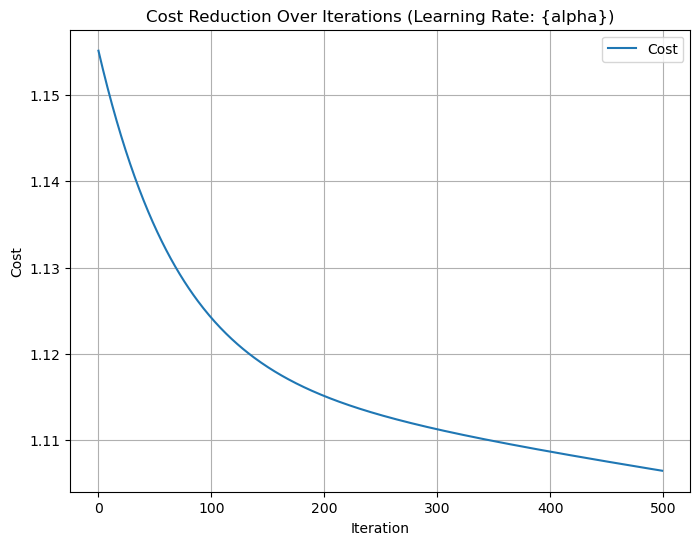

Initial Cost: 1.1551154644885329
Final Cost: 1.1064795660262512


In [11]:
def test_gradient_descent_softmax_with_plot():
  # Generate synthetic data for testing
  np.random.seed(0)
  n, d, c = 100, 5, 3 # 100 samples, 5 features, 3 classes
  X = np.random.rand(n, d)
  y_indices = np.random.randint(0, c, size=n)
  y = np.zeros((n, c))
  y[np.arange(n), y_indices] = 1 # One-hot encoding

  # Initialize weights and biases
  b = np.random.rand(c)
  W = np.random.rand(d, c)

  # Parameters for gradient descent
  alpha = 0.01 # Learning rate
  n_iter = 500 # Number of iterations
  
  # Run gradient descent
  W_opt, b_opt, cost_history = gradient_descent_softmax(X, y, W, b, alpha, n_iter, show_cost=False)
  print(W_opt, b_opt, cost_history)
  # Plot the cost history
  plt.figure(figsize=(8, 6))
  plt.plot(range(n_iter), cost_history, label="Cost")
  plt.xlabel("Iteration")
  plt.ylabel("Cost")
  plt.title("Cost Reduction Over Iterations (Learning Rate: {alpha})")
  plt.legend()
  plt.grid()
  plt.show()
  # Final cost should ideally be less than initial cost
  print(f"Initial Cost: {cost_history[0]}")
  print(f"Final Cost: {cost_history[-1]}")
test_gradient_descent_softmax_with_plot()

In [12]:
def predict_softmax(X, W, b):
    """
    Predict the class labels for input data.
    Parameters:
        X (numpy.ndarray): Feature matrix of shape (n, d).
        W (numpy.ndarray): Weight matrix of shape (d, c).
        b (numpy.ndarray): Bias vector of shape (c,).

    Returns:
        numpy.ndarray: Predicted class labels of shape (n,).
    """
    z = (X @ W) + b.reshape(1, -1)
    y_pred = softmax(z)
    return np.argmax(y_pred, axis=1)

In [13]:
def test_predict_softmax():
    np.random.seed(0)
    # Generate synthetic data for testing
    n, d, c = 10, 5, 3  # 10 samples, 5 features, 3 classes
    X = np.random.rand(n, d)
    W = np.random.rand(d, c)
    b = np.random.rand(c)

    predictions = predict_softmax(X, W, b)
    # Check the shape of the output
    assert predictions.shape == (
        n,
    ), f"Shape mismatch: expected {(n,)}, got {predictions.shape}"
    # Verify that all predicted labels are within the range of class indices
    assert np.all(predictions >= 0) and np.all(
        predictions < c
    ), f"Predictions out of range: expected 0 to {c-1}, got {predictions}"
    # Check that the predicted labels are integers
    assert np.issubdtype(
        predictions.dtype, np.integer
    ), f"Predictions are not integers: {predictions.
  dtype}"
    print("All tests passed for predict_softmax!")


# Run the test
test_predict_softmax()

All tests passed for predict_softmax!


In [14]:
def evaluate_classification(y_true, y_pred):
  """
    Evaluate the classification performance using confusion matrix, precision, recall, and F1-score.
    Parameters:
    y_true (numpy.ndarray): True class labels of shape (n,).
    y_pred (numpy.ndarray): Predicted class labels of shape (n,).
    Returns:
    tuple: Confusion matrix, precision, recall, and F1-score.
  """

  from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
  cm = confusion_matrix(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
  recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
  f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
  return cm, precision, recall, f1

In [15]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Load the Iris dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name="target")
# Display information about the dataset before cleaning
print("Dataset Info:")
X.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [16]:
print("\nDataset Description Before Cleaning:")
X.describe()


Dataset Description Before Cleaning:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [22]:
X = iris.data # Creates a Feature Matrix
y = iris.target # Creates a Target Vector
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))
y_onehot

<class 'numpy.ndarray'>


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

In [40]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y)

print(X.shape, y_onehot.shape, y_test.shape, y_train.shape)
# Initialize the scaler and scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Assertions to check the shape of X_train_scaled and X_test_scaled
assert X_train_scaled.shape == (X_train.shape[0], X_train.shape[1]), f"X_train_scaled shape mismatch: {
X_train_scaled.shape}"
assert X_test_scaled.shape == (X_test.shape[0], X_test.shape[1]), f"X_test_scaled shape mismatch: {
X_test_scaled.shape}"
print("Shape assertions passed!")

(150, 4) (150, 3) (30, 3) (120, 3)
Shape assertions passed!



Training Softmax Regression Model:
Iteration 0: Cost = 1.006823
Iteration 100: Cost = 0.319428
Iteration 200: Cost = 0.251376
Iteration 300: Cost = 0.211741
Iteration 400: Cost = 0.185004
Iteration 500: Cost = 0.165744
Iteration 600: Cost = 0.151226
Iteration 700: Cost = 0.139898
Iteration 800: Cost = 0.130812
Iteration 900: Cost = 0.123360
Iteration 999: Cost = 0.117192


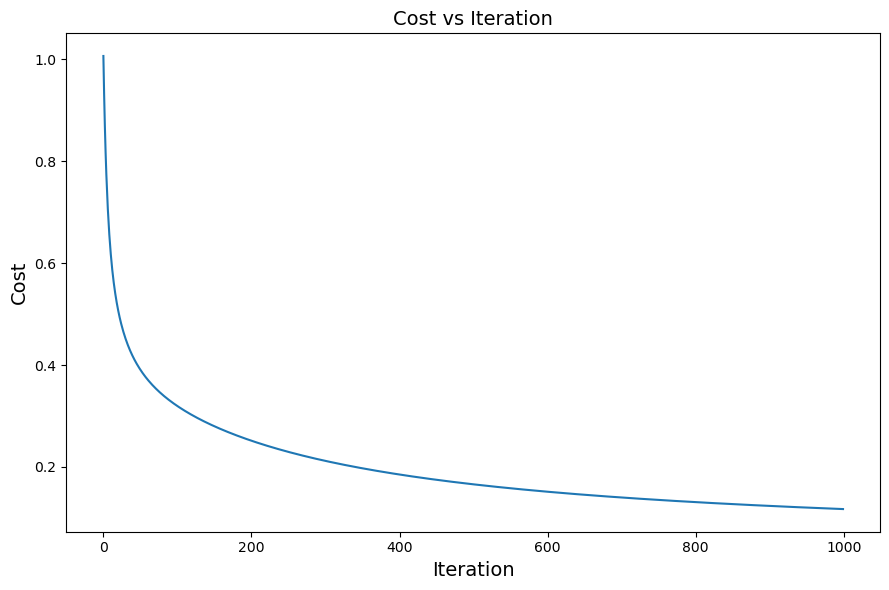

In [41]:
# Intitalizations:
num_classes = y_train.shape[1]
num_features = X_train_scaled.shape[1]
W = np.zeros((num_features, num_classes))
b = np.zeros(num_classes)
alpha = 0.1
n_iter = 1000

print("\nTraining Softmax Regression Model:")
W, b, cost_history = gradient_descent_softmax(X_train_scaled, y_train, W, b, alpha, n_iter, show_cost=True)
#Plot Cost Vs. Iterations:
plt.figure(figsize=(9, 6))
plt.plot(cost_history)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Cost", fontsize=14)
plt.title("Cost vs Iteration", fontsize=14)
plt.tight_layout()
plt.show()
plt.show()

In [42]:
# Test model
y_train_pred = predict_softmax(X_train_scaled, W, b)
y_test_pred = predict_softmax(X_test_scaled, W, b)

print(y_test_pred.shape, y_test.shape)
# Evaluate train and test performance
train_cost = cost_softmax(X_train_scaled, y_train, W, b)
test_cost = cost_softmax(X_test_scaled, y_test, W, b)
print(f"\nTrain Loss (Cost): {train_cost:.4f}")
print(f"Test Loss (Cost): {test_cost:.4f}")

(30,) (30, 3)

Train Loss (Cost): 0.1172
Test Loss (Cost): 0.1575



Test Accuracy: 93.33%

Confusion Matrix:
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
Precision: 0.93
Recall: 0.93
F1-Score: 0.93


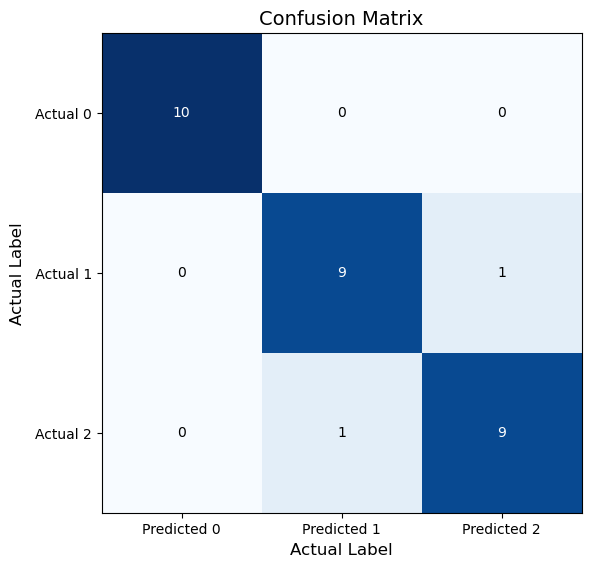

In [43]:
# Accuracy on test data
y_test_true = np.argmax(y_test, axis=1)

test_accuracy = np.mean(y_test_pred == y_test_true) * 100
print(f"\nTest Accuracy: {test_accuracy:.2f}%")

# Evaluation
cm, precision, recall, f1 = evaluate_classification(y_test_true, y_test_pred)
print("\nConfusion Matrix:")
print(cm)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
# Visualizing Confusion Matrix
# Visualization
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm, cmap='Blues') # Use a color map for better visualization
# Set tick labels for the axes
ax.set_xticks(range(3))
ax.set_yticks(range(3))
ax.set_xticklabels(['Predicted 0', 'Predicted 1', 'Predicted 2'])
ax.set_yticklabels(['Actual 0', ' Actual 1', 'Actual 2'])
# Add labels to each cell in the confusion matrix
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > np.max(cm) / 2 else 'black')

# Add grid lines and axis labels
ax.grid(False)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel( 'Actual Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)
plt.tight_layout()
plt.show()